# Prétraitement et Extraction de Features - Étude de Faisabilité

Ce notebook a pour objectif de réaliser une étude de faisabilité pour la classification automatique d'articles e-commerce en différentes catégories à partir de leurs descriptions textuelles. Nous allons d'abord effectuer un prétraitement des données, puis extraire des caractéristiques à l'aide de différentes méthodes de vectorisation : **CountVectorizer**, **Tf-idf**, **Word2Vec**, **BERT** et **Universal Sentence Encoder (USE)**. 

Ensuite, nous utiliserons des techniques de réduction de dimension (PCA, t-SNE) et de clustering (KMeans) pour visualiser les données et évaluer la qualité des regroupements à l'aide de l'indice **Adjusted Rand Index (ARI)**.

## Étapes :
1. Chargement des données
2. Prétraitement des textes
3. Vectorisation et extraction de features avec différentes méthodes
4. Réduction de dimension et clustering
5. Visualisation des résultats et comparaison des performances

In [23]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# TensorFlow and PyTorch
import tensorflow_hub as hub
import torch

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Word Embeddings
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

## 1. Chargement des données

Nous commençons par charger les données d'articles disponibles dans un fichier CSV. Ce fichier contient les informations sur les produits, y compris leur nom, description, et la catégorie à laquelle ils appartiennent.

In [2]:
data = pd.read_csv('flipkart_sample.csv')
descriptions = data[['product_name', 'description', 'product_category_tree']]
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


## 2. Prétraitement des textes

Dans cette étape, nous nettoyons les descriptions et noms des produits. Les opérations de prétraitement incluent :
- La suppression de la ponctuation
- La mise en minuscules
- La suppression des stopwords (mots vides)
- La lemmatisation pour réduire les mots à leur forme canonique

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def nettoyer_texte(text):
    """
    Nettoie le texte en appliquant plusieurs transformations :
    - Suppression de la ponctuation
    - Mise en minuscules
    - Suppression des stopwords
    - Lemmatisation
    
    Args:
    text (str): Le texte brut à nettoyer.
    
    Returns:
    str: Le texte nettoyé et lemmatisé.
    """
    try:
        # Suppression de la ponctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Mise en minuscules
        text = text.lower()
        # Suppression des stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])
        # Lemmatisation
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    except AttributeError:
        print(f"Erreur : le texte fourni n'est pas une chaîne valide : {text}")
        return ""
    return text

# Création d'une copie complète pour éviter l'avertissement SettingWithCopyWarning
descriptions = data[['product_name', 'description', 'product_category_tree']].copy()

# Nettoyage des colonnes 'description' et 'product_name'
descriptions['cleaned_description'] = descriptions['description'].apply(nettoyer_texte)
descriptions['cleaned_product_name'] = descriptions['product_name'].apply(nettoyer_texte)

In [4]:
descriptions.head()

,product_name,description,product_category_tree,cleaned_description,cleaned_product_name
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",key feature elegance polyester multicolor abst...,elegance polyester multicolor abstract eyelet ...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",specification sathiyas cotton bath towel 3 bat...,sathiyas cotton bath towel
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",key feature eurospa cotton terry face towel se...,eurospa cotton terry face towel set
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature santosh royal fashion cotton print...,santosh royal fashion cotton printed king size...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",key feature jaipur print cotton floral king si...,jaipur print cotton floral king sized double b...


## 3. Vectorisation et extraction de features

Nous appliquons ici deux techniques de vectorisation pour convertir le texte en caractéristiques numériques :
- **CountVectorizer** : convertit le texte en comptant la fréquence des mots.
- **Tf-idf** : calcule la fréquence inverse du document pour pondérer l'importance des mots.

In [5]:
# Initialiser les deux vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Appliquer les deux vectorizers sur les données
descriptions['cleaned_full_text'] = descriptions['cleaned_product_name'] + ' ' + descriptions['cleaned_description']

try:
    count_matrix = count_vectorizer.fit_transform(descriptions['cleaned_full_text'])
    tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions['cleaned_full_text'])
except ValueError as e:
    print(f"Erreur lors de la vectorisation : {e}")

In [6]:
# Afficher la forme des matrices
print("Count Matrix shape:", count_matrix.shape)
print("Tf-idf Matrix shape:", tfidf_matrix.shape)

Count Matrix shape: (1050, 6120)
Tf-idf Matrix shape: (1050, 6120)


In [7]:
# Fonction pour nettoyer la colonne product_category_tree
def nettoyer_categories(cat):
    """
    Nettoie et formate une chaîne de texte représentant une catégorie de produit.
    
    Cette fonction effectue les opérations suivantes :
    - Remplacement des balises HTML telles que `&gt;` par `>`.
    - Suppression des crochets et guillemets.
    - Extraction de la première partie d'une chaîne séparée par '>>'.
    
    Args:
    cat (str): Chaîne de texte représentant une catégorie de produit.
    
    Returns:
    str: Catégorie nettoyée et formatée. Renvoie 'Unknown' si une erreur est rencontrée ou si l'entrée n'est pas une chaîne valide.
    """
    try:
        if isinstance(cat, str):
            # Remplacer les balises HTML
            cat = re.sub(r"&gt;", ">", cat)
            # Enlever les crochets et guillemets
            cat = re.sub(r"[\[\]\"]", "", cat)
            # Extraire uniquement la première partie avant >>
            return cat.split(">>")[0].strip()
    except Exception as e:
        print(f"Erreur lors du nettoyage de la catégorie : {e}")
    return 'Unknown'

# Appliquer la fonction à la colonne product_category_tree
descriptions['real_categories'] = descriptions['product_category_tree'].apply(nettoyer_categories)

# Utiliser ces catégories réelles pour les visualiser
categories = descriptions['real_categories']

## 4. Réduction de dimension et clustering

Pour visualiser les données dans un espace 2D, nous utilisons deux techniques :
- **PCA** (Analyse en Composantes Principales) pour réduire les dimensions tout en conservant 90% de la variance des données.
- **t-SNE** pour projeter les données sur un plan 2D.

Ensuite, nous appliquons l'algorithme **KMeans** pour regrouper les articles en clusters, et nous calculons la similarité entre les clusters et les catégories réelles à l'aide de l'indice Adjusted Rand Index (ARI). L'indice ARI est une mesure de similarité entre les clusters trouvés et les catégories réelles. Un score proche de 1 signifie que les clusters sont bien alignés avec les catégories, tandis qu'un score proche de 0 indique un faible alignement.

In [8]:
def plot_result(features, n_clusters=7, random_state=42):
    """
    Applique PCA et t-SNE pour réduire les dimensions des features, puis 
    effectue un clustering avec KMeans et affiche les résultats.

    Args:
    features (scipy.sparse.csr_matrix): La matrice des features après vectorisation.
    n_clusters (int): Le nombre de clusters pour KMeans. (par défaut: 7)
    random_state (int): L'état aléatoire pour la reproductibilité. (par défaut: 42)
    
    Returns:
    None
    """
    try:
        # Vérifier si la matrice est sparse
        if sp.issparse(features):
            # Convertir en dense array si elle est sparse
            features = features.toarray()

        # PCA avec 90% de la variance retenue
        pca = PCA(n_components=0.9)
        matrix_pca = pca.fit_transform(features)

        # Réduction de dimension avec t-SNE
        tsne = TSNE(n_components=2, random_state=random_state)
        matrix_tsne = tsne.fit_transform(matrix_pca)
        
    except ValueError as e:
        print(f"Erreur lors de la réduction de dimension PCA/TSNE : {e}")
        return

    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans_labels = kmeans.fit_predict(matrix_tsne)
    except ValueError as e:
        print(f"Erreur lors du clustering KMeans : {e}")
        return

    ari = adjusted_rand_score(categories.astype('category').cat.codes, kmeans_labels)
    print(f"ARI : {np.round(ari, 2)}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    fig.suptitle('Comparaison des catégories et clusters', fontsize=16)

    # Visualisation des catégories réelles
    scatter1 = ax1.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1], 
                           c=categories.astype('category').cat.codes, 
                           cmap='viridis', alpha=0.7)

    # Générer la légende avec les vraies catégories
    handles, labels = scatter1.legend_elements()
    ax1.legend(handles, categories.astype('category').cat.categories, title="Catégories Réelles")

    ax1.set_title('Visualisation TSN-e avec catégories')
    ax1.set_xlabel('Composante 1 (t-SNE)')
    ax1.set_ylabel('Composante 2 (t-SNE)')

    # Visualisation des clusters KMeans
    scatter2 = ax2.scatter(matrix_tsne[:, 0], matrix_tsne[:, 1], 
                           c=kmeans_labels, cmap='viridis', alpha=0.7)
    
    ax2.set_title('Visualisation TSN-e avec clusters')
    ax2.set_xlabel('Composante 1 (t-SNE)')
    ax2.set_ylabel('Composante 2 (t-SNE)')

    # Ajouter une légende pour les clusters
    handles2, labels2 = scatter2.legend_elements()
    ax2.legend(handles2, labels2, title="Clusters KMeans")

    plt.tight_layout()
    plt.show()

## 5. Visualisation des résultats

Nous affichons ici deux visualisations comparatives, chacune générée à partir d'une méthode différente de vectorisation :
1. La première visualisation utilise les données vectorisées par **CountVectorizer**.
2. La seconde visualisation utilise les données vectorisées par **Tf-idf**.

Dans chaque visualisation, nous affichons :
- Les articles en fonction de leurs **catégories réelles**.
- Les **clusters** obtenus via l'algorithme KMeans.

ARI : 0.4


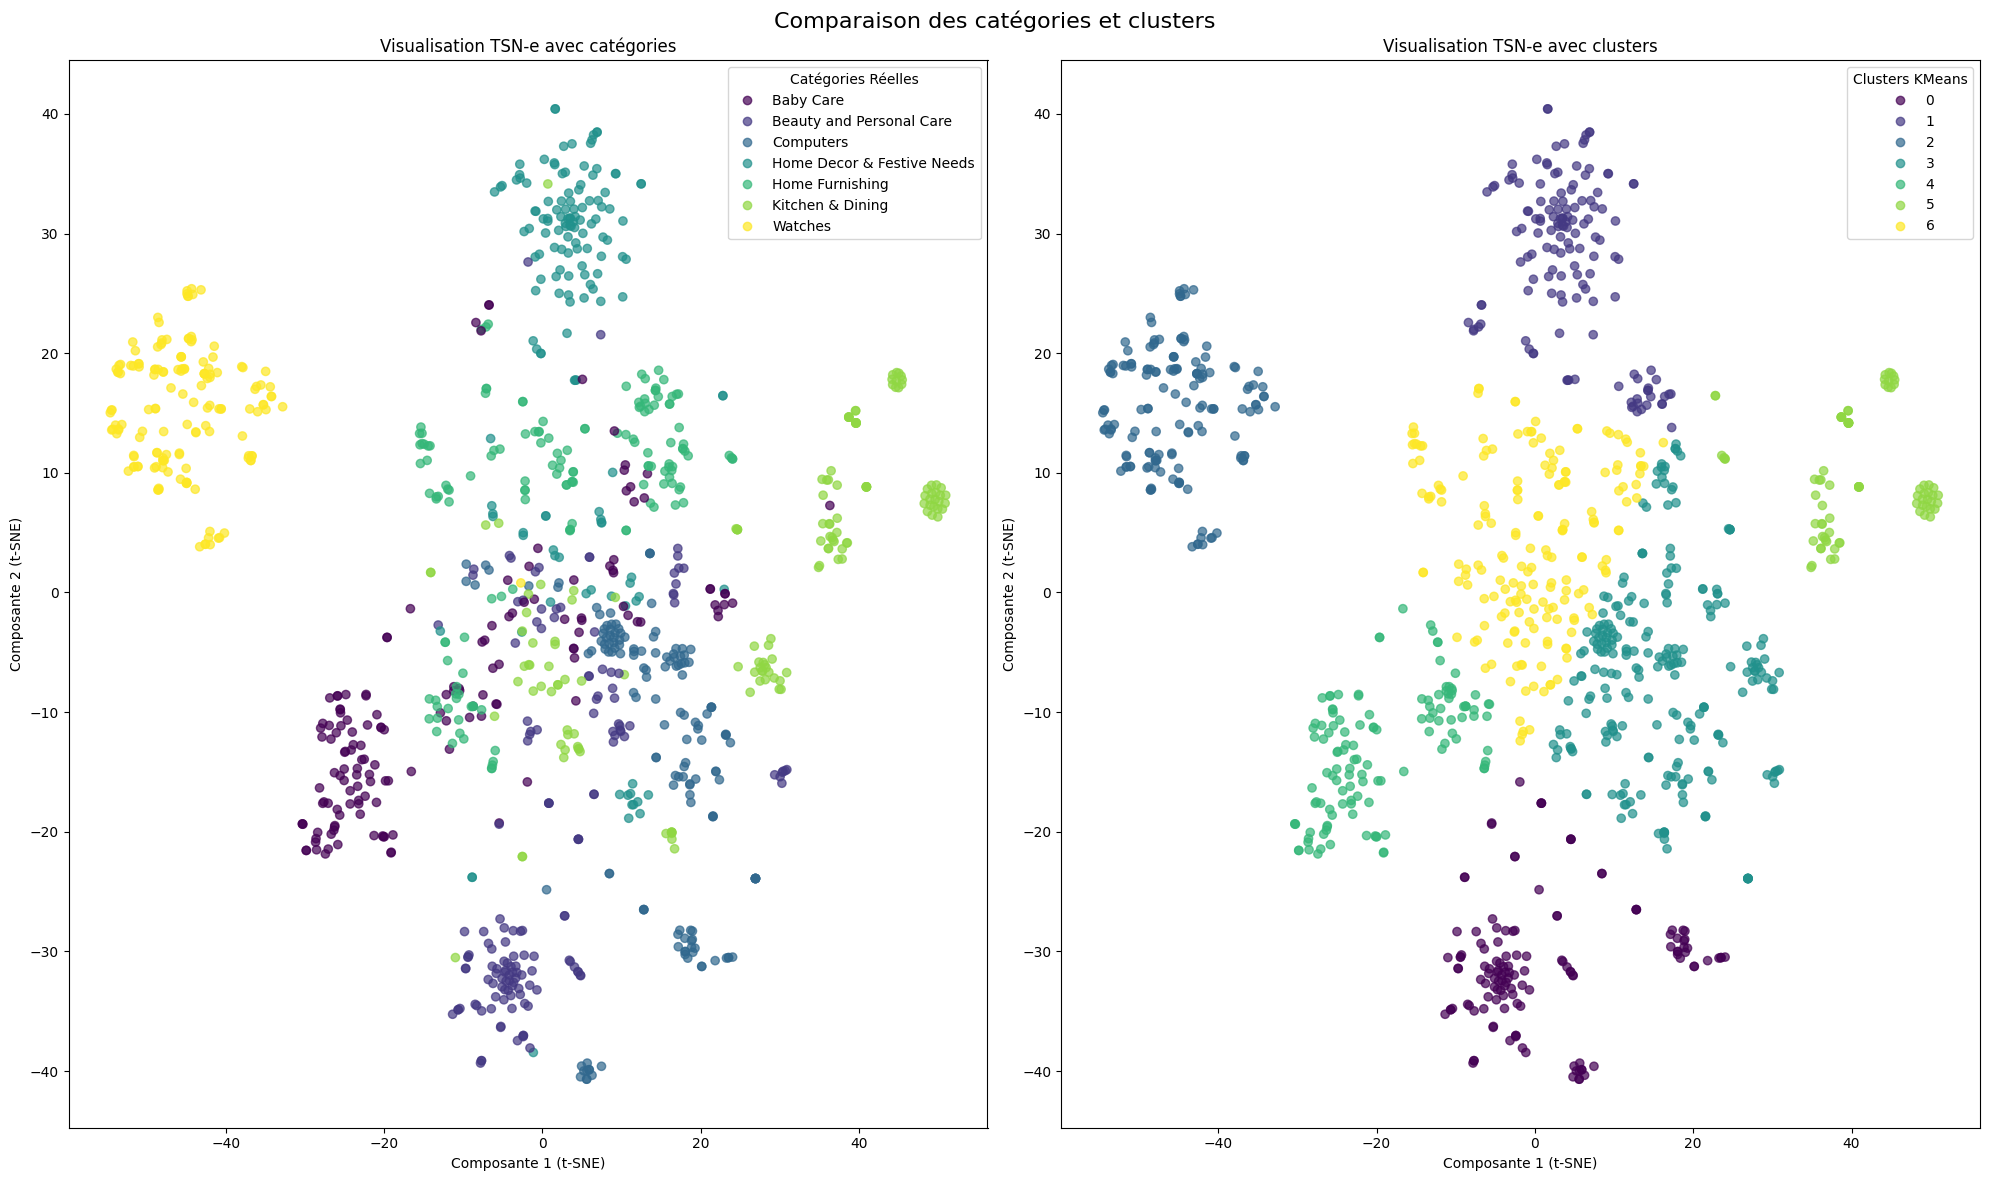

In [9]:
# Visualisation avec CountVectorizer
plot_result(count_matrix)

ARI : 0.54


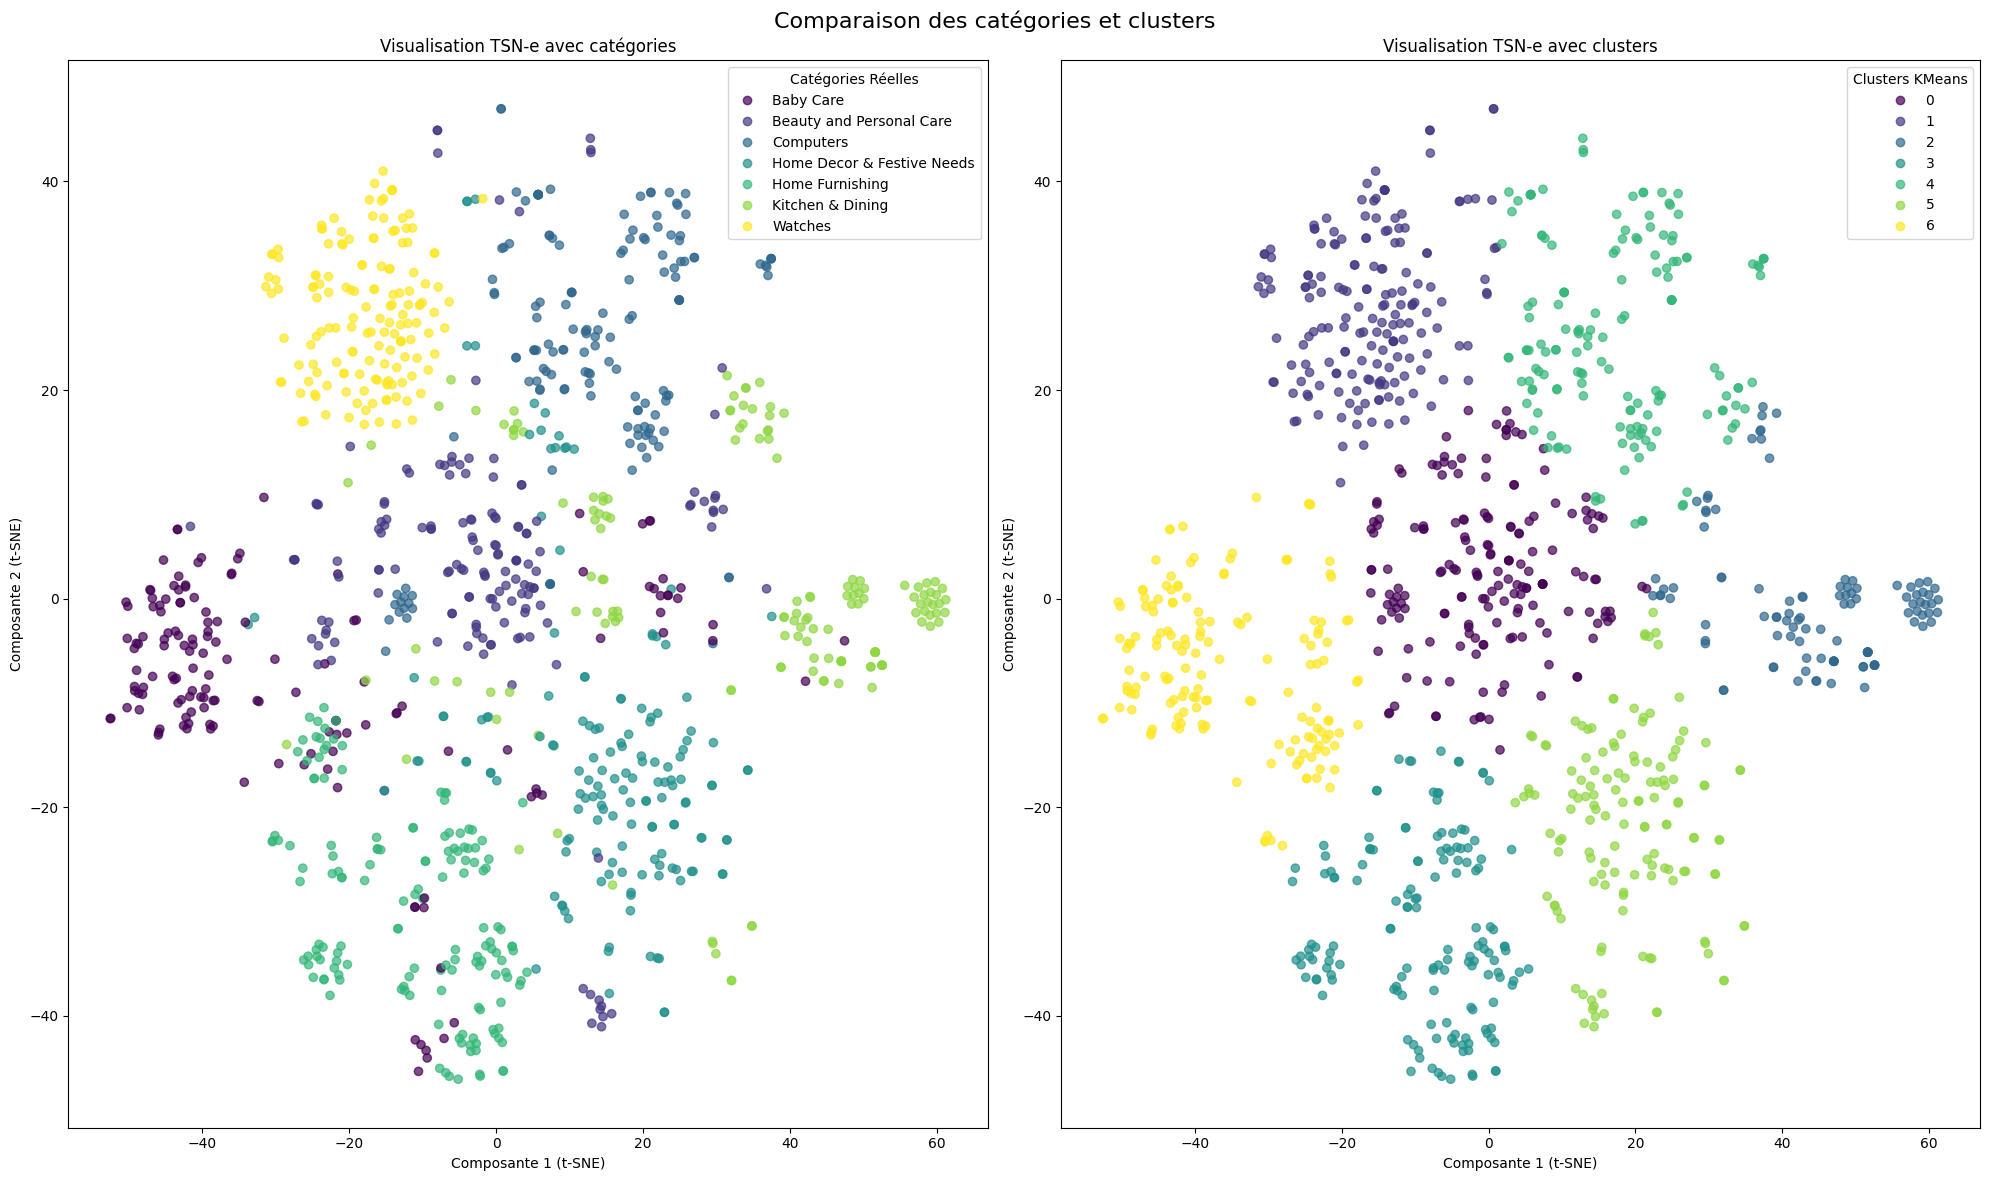

In [10]:
# Visualisation avec Tf-idf
plot_result(tfidf_matrix)

# Conclusion

L'analyse menée avec **CountVectorizer** et **Tf-idf** a montré des résultats intéressants. Nous avons obtenu un ARI de **0.4** avec **CountVectorizer** et un ARI de **0.54** avec **Tf-idf**, ce qui indique un bon alignement entre les clusters générés et les catégories réelles des articles.

Cependant, pour aller plus loin dans l'exploration de la sémantique des descriptions, nous allons essayer des méthodes plus avancées telles que **Word2Vec**, **BERT**, et **Universal Sentence Encoder (USE)**. Ces modèles d'embeddings sont conçus pour capturer des relations plus profondes entre les mots, et nous espérons qu'ils permettront d'améliorer encore les performances du clustering. 

## Exploration des Méthodes d'Embeddings Avancées

Après avoir obtenu des résultats intéressants avec **CountVectorizer** et **Tf-idf**, nous allons explorer des méthodes plus avancées pour capturer la sémantique des descriptions de produits. Nous allons utiliser :
- **Word2Vec** : Un modèle de langage qui apprend des représentations vectorielles des mots basées sur leur contexte.
- **BERT** : Un modèle de langage bidirectionnel pré-entraîné, conçu pour comprendre des relations complexes dans le texte.
- **Universal Sentence Encoder (USE)** : Un modèle qui produit des embeddings de phrases, capturant la signification des phrases entières.

Ces méthodes permettront de comparer les performances du clustering sur des embeddings plus sophistiqués, potentiellement mieux adaptés aux descriptions complexes des produits.

### Utilisation de Word2Vec

Nous allons entraîner un modèle **Word2Vec** sur les descriptions de produits pour apprendre des représentations vectorielles des mots basées sur leur contexte. Chaque description de produit sera représentée par la moyenne des embeddings des mots qui la composent. 

Une fois les embeddings générés, nous appliquerons les mêmes techniques de réduction de dimension (PCA, t-SNE) et de clustering (KMeans) que précédemment pour visualiser et analyser les résultats.

In [11]:
# Préparation des données pour Word2Vec
descriptions['tokenized_description'] = descriptions['cleaned_description'].apply(lambda x: x.split())

In [12]:
# Entraînement du modèle Word2Vec
word2vec_model = Word2Vec(sentences=descriptions['tokenized_description'])

In [13]:
def get_embedding(tokens):
    """
    Calcule l'embedding moyen pour une liste de tokens avec Word2Vec.

    Args:
        tokens (list): Liste de mots.

    Returns:
        np.ndarray: Vecteur moyen des embeddings des tokens présents dans le modèle, 
        ou un vecteur nul si aucun token n'est trouvé.
    """
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

# Appliquer cette fonction pour chaque description
descriptions['embedding'] = descriptions['tokenized_description'].apply(get_embedding)

ARI : 0.21


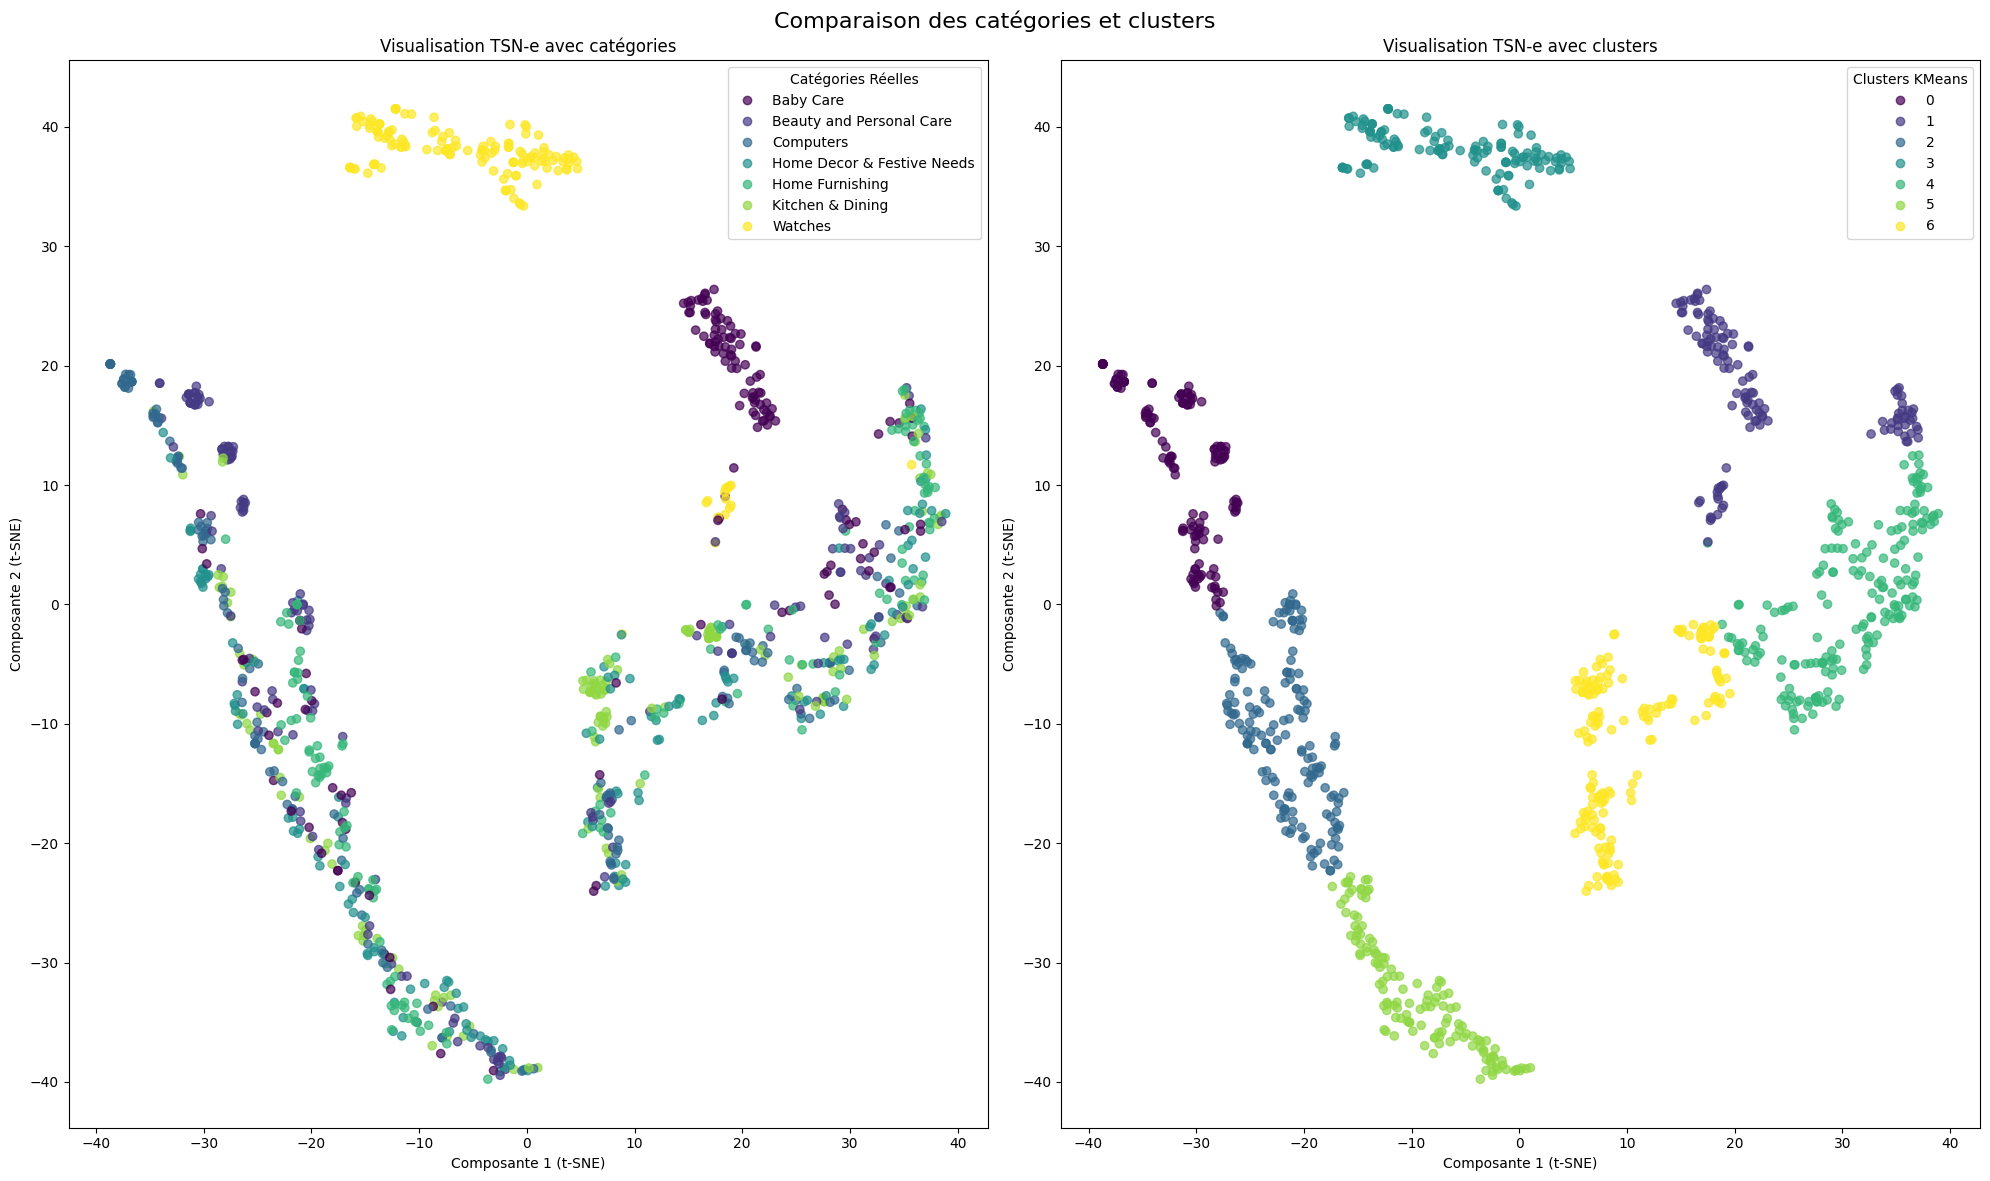

In [14]:
# Conversion des embeddings en matrice pour pouvoir appliquer les techniques de réduction de dimension et clustering
embedding_matrix = np.vstack(descriptions['embedding'].values)

# Réutiliser la fonction plot_result avec les embeddings Word2Vec
plot_result(embedding_matrix)

### Word2Vec

Avec **Word2Vec**, nous avons obtenu un **ARI de 0.21**, ce qui est inférieur aux résultats obtenus avec **CountVectorizer** et **Tf-idf**. Ce score reflète des regroupements de catégories moins précis, probablement parce que **Word2Vec** se base sur des relations contextuelles entre les mots, ce qui peut être moins efficace pour des descriptions de produits relativement courtes ou très spécifiques.

Le graphique montre que les clusters ne correspondent pas parfaitement aux catégories réelles, avec certains regroupements qui sont mélangés, surtout pour des catégories proches dans le vocabulaire mais différentes en sens, comme "Home Furnishing" et "Home Decor & Festive Needs". Cependant, cette méthode reste intéressante pour capturer des relations contextuelles et pourrait être améliorée avec des ajustements d'hyperparamètres.

### Utilisation de BERT

Nous allons utiliser un modèle pré-entraîné **BERT** de Hugging Face pour obtenir des embeddings des descriptions de produits. BERT, étant bidirectionnel, est capable de capturer des relations contextuelles plus complexes entre les mots, ce qui pourrait améliorer les résultats du clustering.

Comme pour les autres méthodes, nous allons réduire la dimensionnalité des embeddings obtenus avec **PCA** et **t-SNE**, et appliquer le clustering avec **KMeans**.

In [15]:
# Charger le tokenizer et le modèle pré-entraîné BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [16]:
def get_bert_embedding(text):
    """
    Calcule l'embedding d'une séquence textuelle à partir de BERT.

    Args:
        text (str): La description textuelle à convertir en embedding.

    Returns:
        np.ndarray: Vecteur d'embedding obtenu à partir de la dernière couche cachée 
        de BERT, moyenné sur les tokens de la séquence.
    """
    # Tokenizer la description et créer les tokens tensor
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
    # Obtenir les embeddings avec le modèle BERT
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # Utiliser la dernière couche cachée de BERT (outputs.last_hidden_state)
    last_hidden_states = outputs.last_hidden_state
    # Calculer la moyenne des embeddings sur les tokens de la séquence
    embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
    
    return embedding

In [17]:
# Générer les embeddings BERT pour chaque description
descriptions['bert_embedding'] = descriptions['cleaned_description'].apply(get_bert_embedding)

ARI : 0.31


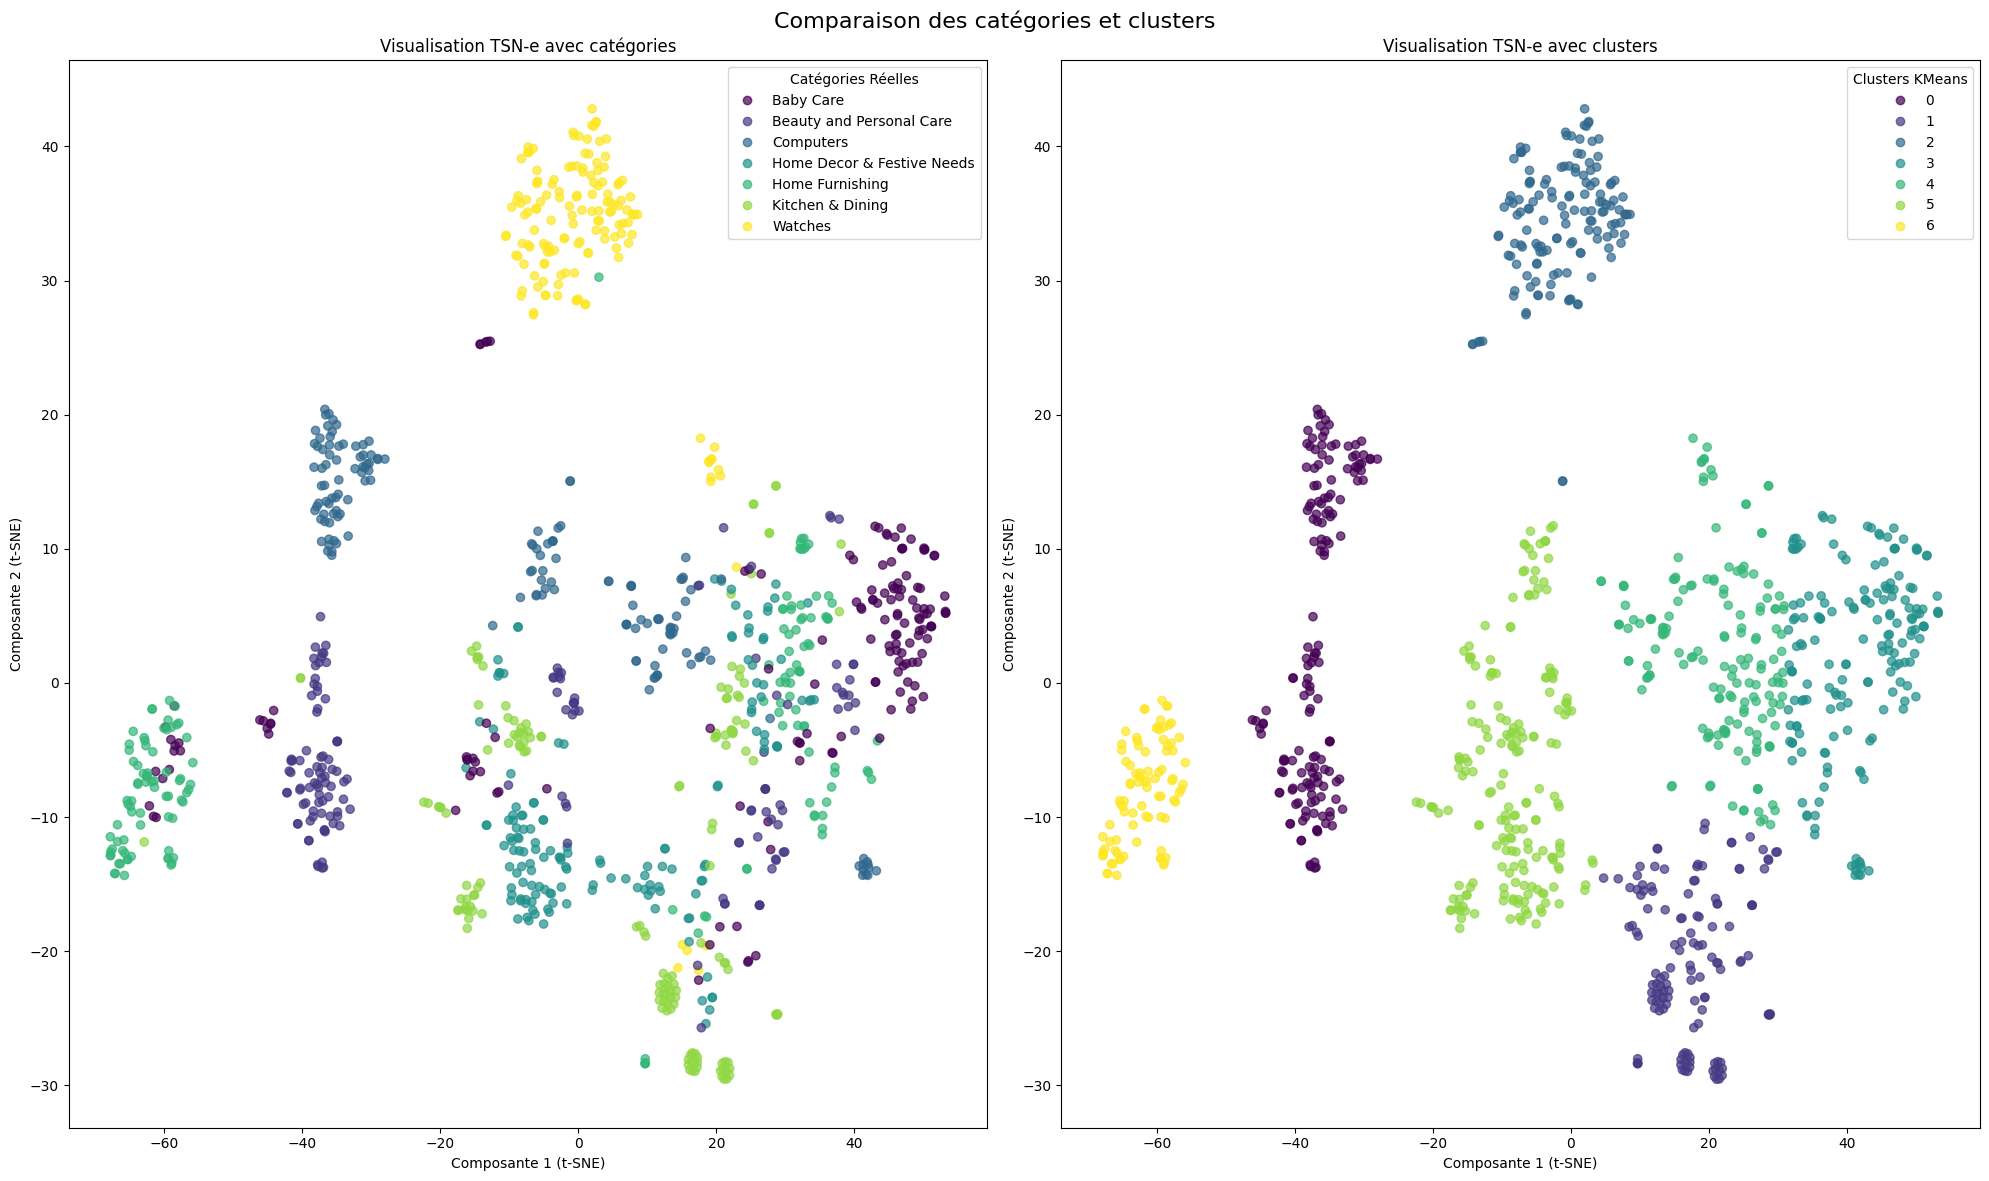

In [18]:
# Conversion des embeddings en matrice
bert_embedding_matrix = np.vstack(descriptions['bert_embedding'].values)

# Réutiliser la fonction plot_result avec les embeddings BERT
plot_result(bert_embedding_matrix)

### BERT

L'application de **BERT** a produit un **ARI de 0.31**, ce qui montre une amélioration par rapport à **Word2Vec**. BERT, étant un modèle bidirectionnel pré-entraîné, est capable de capturer des relations contextuelles plus complexes entre les mots dans les descriptions des produits, ce qui se reflète dans une meilleure séparation des clusters.

Le graphique montre que les clusters obtenus avec **BERT** correspondent mieux aux catégories réelles, bien que certains chevauchements persistent, notamment dans les catégories **Home Furnishing** et **Home Decor & Festive Needs**. Cela souligne la capacité de **BERT** à capturer des nuances plus fines dans les descriptions, mais il pourrait encore être optimisé en utilisant des techniques de fine-tuning adaptées aux spécificités des produits.

### Utilisation de Universal Sentence Encoder (USE)

Nous allons maintenant utiliser **Universal Sentence Encoder (USE)**, un modèle qui produit des embeddings de phrases entières. Ce modèle est conçu pour capturer la signification globale d'une phrase, ce qui le rend particulièrement utile pour des descriptions de produits complètes.

Nous appliquerons ensuite les mêmes techniques de réduction de dimension et de clustering afin de comparer les résultats avec les autres méthodes.

In [19]:
# Télécharger le modèle Universal Sentence Encoder via TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [20]:
# Fonction pour obtenir l'embedding USE d'une description
def get_use_embedding(text):
    """
    Calcule l'embedding d'une séquence textuelle à partir du modèle Universal Sentence Encoder (USE).

    Args:
        text (str): La description textuelle à convertir en embedding.

    Returns:
        np.ndarray: Vecteur d'embedding de la phrase obtenu à partir de USE.
    """
    # Passer la description dans le modèle USE pour obtenir l'embedding
    embedding = use_model([text])
    return embedding.numpy().squeeze()

In [21]:
# Générer les embeddings USE pour chaque description
descriptions['use_embedding'] = descriptions['cleaned_description'].apply(get_use_embedding)

ARI : 0.37


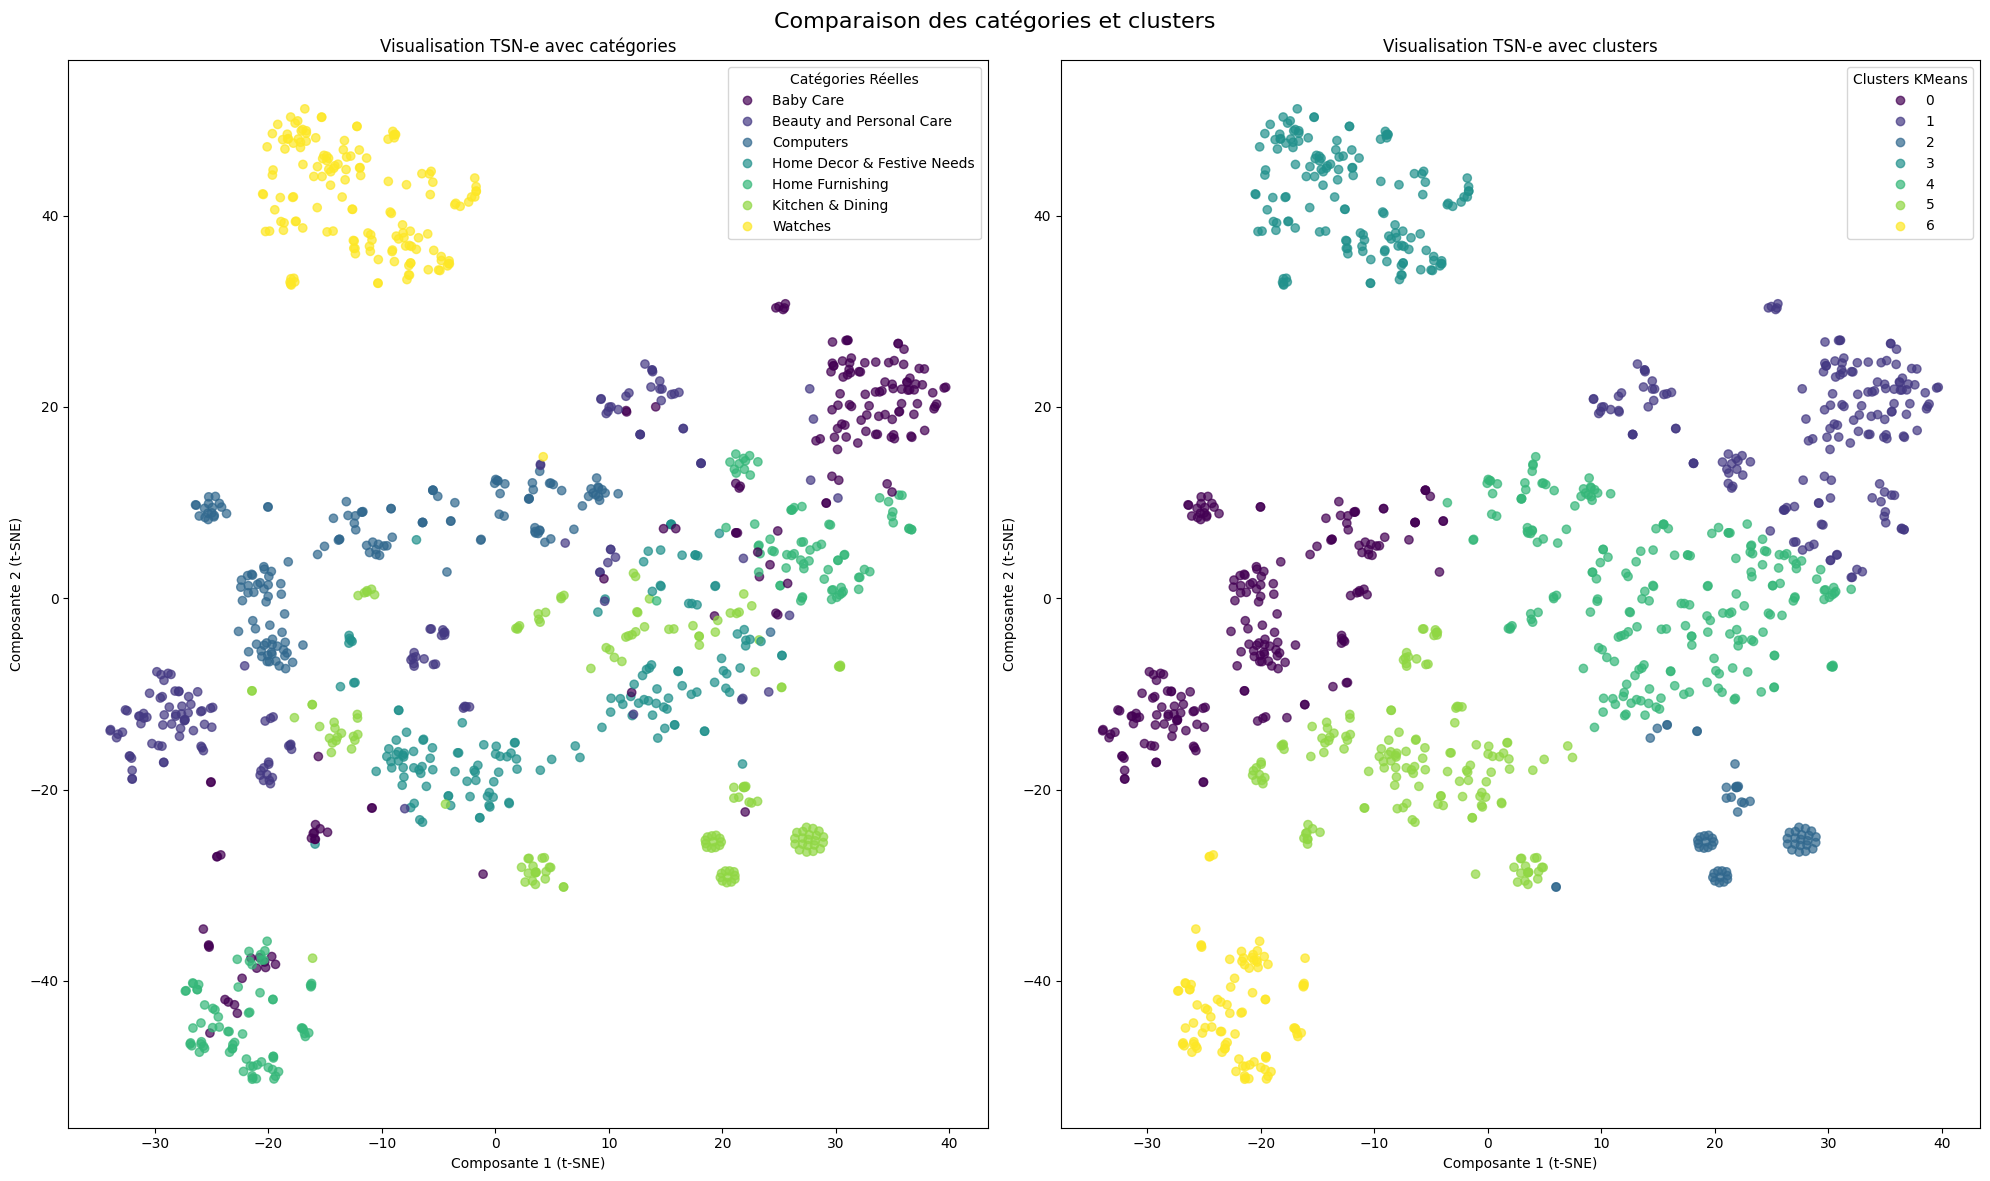

In [22]:
# Conversion des embeddings en matrice
use_embedding_matrix = np.vstack(descriptions['use_embedding'].values)

# Réutiliser plot_result pour visualiser les résultats avec USE
plot_result(use_embedding_matrix)

### Universal Sentence Encoder (USE)

L'utilisation de **Universal Sentence Encoder (USE)** a produit un **ARI de 0.37**, ce qui est supérieur aux résultats obtenus avec **Word2Vec** et **BERT**. USE est conçu pour capturer la signification globale des phrases, ce qui semble mieux correspondre aux descriptions des produits dans notre cas.

Le graphique montre une meilleure séparation des clusters, avec une correspondance plus précise avec les catégories réelles. Les regroupements sont plus cohérents, en particulier pour les catégories **Watches** et **Baby Care**, qui sont bien distinctes. Cette méthode est particulièrement adaptée pour capturer la sémantique des descriptions plus longues et complexes, et elle pourrait être encore améliorée en ajustant les paramètres du modèle.

## Conclusion Globale

L'étude menée dans ce notebook visait à évaluer la faisabilité d'une classification automatique des produits à partir de leurs descriptions textuelles. Nous avons exploré plusieurs techniques de vectorisation (**CountVectorizer**, **Tf-idf**, **Word2Vec**, **BERT**, **Universal Sentence Encoder**) et appliqué des algorithmes de réduction de dimension et de clustering non supervisé pour visualiser et évaluer les regroupements obtenus.

Les résultats montrent que :

- **CountVectorizer** et **Tf-idf** ont donné de bons résultats avec des ARI respectivement de **0.4** et **0.54**, confirmant leur efficacité pour des descriptions courtes et précises.
- Les modèles d'embeddings comme **Word2Vec**, **BERT**, et **USE** ont également montré des résultats intéressants, avec un meilleur score pour **USE** à **0.37**, démontrant leur capacité à capturer des relations sémantiques plus complexes.

### Conclusion sur la faisabilité :
L'analyse a démontré qu'il est possible de regrouper automatiquement des articles similaires à partir de leurs descriptions textuelles. Les différentes approches de vectorisation, combinées à des techniques de réduction de dimension et de clustering, permettent de regrouper des produits avec une similarité notable, ce qui confirme la faisabilité du projet. Bien que des améliorations soient envisageables, notamment en affinant les modèles d'embeddings, l'approche actuelle donne des résultats prometteurs pour un moteur de classification.